<table align="left">
  <td>
    <a href="https://tinyurl.com/2bxjgvzn" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Project 2: Car Vision

En este proyecto se va a crear un modelo de clasificación de imágenes para identificar diferentes tipos de vehículos. El conjunto de datos car196 se puede descargar desde [aquí](http://ai.stanford.edu/~jkrause/cars/car_dataset.html). El conjunto de datos contiene 16,185 imágenes de 196 clases de vehículos. El conjunto de datos se divide en 8,144 imágenes de entrenamiento, 8041 imágenes de prueba.

El objetivo de este proyecto es superar el rendimiento de **77.72% accuracy obtenido con 10 epocas de entrenamiento**, utilizando transfer learning con un modelo pre-entrenado de ResNet. El artículo de referencia se puede encontrar [aquí](https://towardsdatascience.com/car-model-classification-e1ff09573f4f).

:key: Se realizarán diferentes experimentos para mejorar el rendimiento del modelo. Los experimentos se realizarán en el orden siguiente:

1. Model_v1: 
    1. Entrenar un modelo de extracción de características tomando como base el modelo EfficientNetB0 con sus capas congeladas, durante 5 épocas.
    2. Salvar el modelo entrenado en el paso 1.
    3. Crear callbacks de checkpoint y reducción de la tasa de aprendizaje para el entrenamiento del modelo en el paso 4. 
    4. Cargar el modelo y descongelar las últimas 5 capas del modelo base para entrenar el modelo completo (fine tuning) durante 5 épocas más a una tasa de aprendizaje más baja.
    5. Evaluar el rendimiento del modelo con diferentes imagenes de prueba.

In [1]:
import tensorflow as tf
import helper_functions as hf
from tensorflow import keras
from tensorflow.keras import layers

## 1. Utilizar TensorFlow Datasets para descargar los datos

Para descargar los datos, se utilizará la biblioteca [TensorFlow Datasets](https://www.tensorflow.org/datasets?hl=es-419) (TFDS). TFDS es una biblioteca de TensorFlow que contiene una variedad de datasets listos para usar.


TFDS tiene una función llamada [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load?hl=es-419) que se puede utilizar para descargar un dataset. Esta función toma un nombre de dataset como su argumento y devuelve un objeto [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=es-419) que contiene los datos del dataset.

In [2]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [3]:
# lista de todos los datasets disponibles
datasets_list = tfds.list_builders()
print("cars196" in datasets_list)

True


In [4]:
# importar dataset cars196 https://www.tensorflow.org/datasets/catalog/cars196?hl=es-419
# food101 pesa 1.82 GiB la descarga depende de la velocidad del internet
(train_data, test_data), ds_info = tfds.load(name="cars196",
                                    split=["train", "test"],
                                    shuffle_files=True,
                                    as_supervised=True, # los datos son devueltos en forma de tumple (data,label)
                                    with_info=True,
                                    data_dir="C:/Users/diego/tensorflow_datasets/")

In [6]:
# numero total de datos disponibles en el dataset
num_train_data = tf.data.experimental.cardinality(train_data)
num_test_data = tf.data.experimental.cardinality(test_data)
num_train_data, num_test_data

(<tf.Tensor: shape=(), dtype=int64, numpy=8144>,
 <tf.Tensor: shape=(), dtype=int64, numpy=8041>)

In [10]:
print(ds_info.splits['train'].num_examples)
print(ds_info.splits['test'].num_examples)

8144
8041


### Explorando el dataset cars196

El dataset que se utilizará en este proyecto es el [cars196](https://www.tensorflow.org/datasets/catalog/cars196?hl=es-419) dataset. Este dataset contiene 16,185 imágenes de 196 clases de coches. Cada imagen tiene una resolución de 256x256 píxeles.


In [21]:
# Features of cars196 TFDS
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [22]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012']

In [27]:
# Numero de elementos por clase
# Create a dictionary to store the count of elements per class
class_count = {}

# Iterate over the dataset and count the number of elements per class
for image, label, in train_data:
  label = class_names[label.numpy()]
  if label in class_count:
    class_count[label] += 1
  else:
    class_count[label] = 1

# Print the count of elements per class
#for key, value in class_count.items():
#  print("Class ", key, ": ", value, " elements")

# Get the first 10 items from the dictionary
first_10 = {k: class_count[k] for k in list(class_count.keys())[:10]}

# Print the first 10 items
print("The first 10 items in the dictionary are:")
for key, value in first_10.items():
  print(key, ":", value)

The first 10 items in the dictionary are:
Fisker Karma Sedan 2012 : 44
Land Rover Range Rover SUV 2012 : 43
Dodge Journey SUV 2012 : 44
Audi S5 Coupe 2012 : 43
Chevrolet Silverado 1500 Classic Extended Cab 2007 : 43
Lamborghini Aventador Coupe 2012 : 44
Dodge Charger Sedan 2012 : 41
Nissan Leaf Hatchback 2012 : 42
Volkswagen Golf Hatchback 1991 : 46
Cadillac Escalade EXT Crew Cab 2007 : 45


>:eye: **Nota:** Se puede observar que el dataset cars196 contiene imagenes de 196 tipos de vehiculos diferentes, pero no todas las clases tienen el mismo número de imágenes. Por ejemplo, la clase `Acura RL Sedan 2012 ` tiene 32 imágenes, mientras que la clase `Porsche Panamera Sedan 2012` tiene 44 imágenes. Adicionalmente el número de imagenes por vehiculo es pequeño.

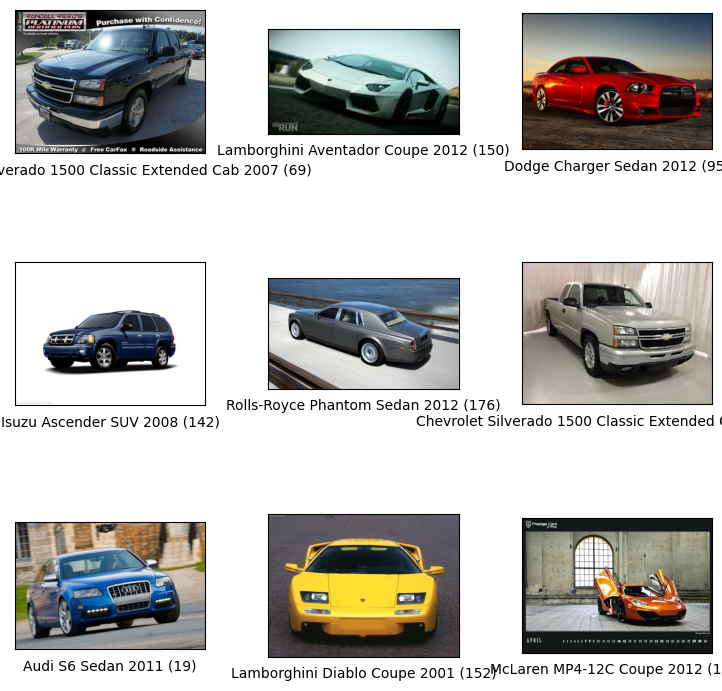

In [7]:
fig = tfds.show_examples(train_data, ds_info)


        Image Shape: (326, 700, 3)
        Image Datatype: <dtype: 'uint8'>
        Target class from cars196: 49
        class name (str form): Buick Enclave SUV 2012
        


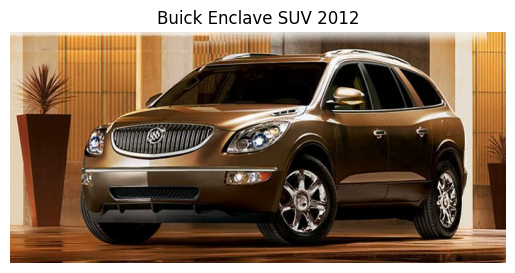

In [8]:
import matplotlib.pyplot as plt
# Obtener una imagen del dataset y graficarla
train_one_sample = train_data.take(1)
train_one_sample
for image, label, in train_one_sample:
    print(f"""
        Image Shape: {image.shape}
        Image Datatype: {image.dtype}
        Target class from cars196: {label}
        class name (str form): {class_names[label.numpy()]}
        """)
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## 2. Crear un pipeline de datos

Que sabemos hasta ahora de nuestro dataset:

- Las imágenes de entrada son de diferentes tamaños.
- Las imágenes no se encuentran normalizadas.
- Las imágenes no se encuentran en batches.
- El tipo de dato es ´uint8´.

Que sabemos del modelo:

- El modelo espera imágenes de entrada de 224x224.
- El modelo espera imágenes de entrada normalizadas (entre 0 y 1).
- El modelo espera imágenes de entrada en batches.
- El modelo espera imágenes de entrada con tipo de dato ´float32´ o ´float16´ debido al mixed_precision training.

Con estos puntos en mente, se crea una función de preprocesamiento para los datos.

:key: **Nota:** Dado que se utilizará como base el modelo preentrenado EfficientNetBX, no es necesario normalizar los datos ya que este modelo incluye la capa de normalización.

La función de preprocesamiento debe tener los siguientes pasos:

1. Convertir el tipo de dato de las imágenes de entrada a `float32` dependiendo del mixed_precision training.
2. Redimensionar las imágenes de entrada a 224x224.
3. Crear batches de las imágenes de entrada.

In [ ]:
def preprocess_img(image, label, img_shape=224):
    """
    Convierte el tipo de datos de las imagenes de ´uint8´ a ´float32´ y
    reshapes la imagen a [img_shape,img_shape,colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    #image = image/255. # no es necesario para efficientNETBX
    return tf.cast(image, tf.float32), label


In [ ]:
# preprocesar una imagen y verificar la sailda
preprocessed_img = preprocess_img(image, label)[0]

In [ ]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Preparar los datos para el modelo

Antes de pasar los datos al modelo, es necesario agrupar los datos en batches. Esto se hace para que el modelo pueda procesar los datos en paralelo. Esto significa que el modelo puede procesar más datos en un tiempo más corto. 

Para convertir los datos en batches de forma eficiente, se utilizan metodos como [`tf.data.Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch?hl=es-419) y [`tf.data.Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch?hl=es-419).

El pipeline quedará en el siguiente orden: 

> Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset

In [ ]:
# Map preprocessing function to training (and parallelize)
# obtener todos los datos y pasarla por la función de preprocesado
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data y convertirla en batches y prefetch it (cargar rapidamente)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map la función de preprocesamiento para los datos de prueba
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

### Configurar mixed_precision training

In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

In [ ]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

## 3.0 Crear un modelo de Extraer Características

El modelo con mixed precision agrega 3 pasos adicionales:

![model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)

In [ ]:
from tensorflow.keras import layers
# crear un modelo base
input_shape = (224,224,3)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# Crear un modelo con la api funcional
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)
model_v1 = keras.Model(inputs, outputs)

# compilar el modelo
model_v1.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])

In [ ]:
model_v1.summary()

In [ ]:
# Verificar si se está usando mixed precision training y
# cuales capas se encuentran congeladas.
for layers in model_v1.layers:
    print(layers.name, layers.trainable, layers.dtype, layers.dtype_policy)

## 4. Entrenar el Modelo de Extracción de Características 

Primero se entrenará el modelo de extracción de características con mixed precision training, luego se aplicará fine-tuning.

In [ ]:
history_car196_FE_v1 = model_v1.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=int(0.15*len(test_data)),
                                 callbacks=[hf.create_tensorboard_callback("car_logs","car196_FE_v1")]

)

In [ ]:
hf.plot_training_curves(history_car196_FE_v1)